In [1]:
#MWA stats
M_course = 8 # number of taps in the coarse PFB
P_course = 512 # number of points in the course PFB
# what is "Kaiser windowing function" is this different than the windowing function in the example notebook?
# this is subsampled into a 512 point FFT - should form 256 1.28 MHz sub-bands
M_fine = 12 # number of taps in the second PFB?
P_fine = 128 # number of points in the second PFB?
# course channel is read out as 16 bit real + 16 bit imagenary

In [2]:
#I can make fake data. But what should that look like? (What does MWA data look like normally before it goes through the PFB?)

In [3]:
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

Define Functions
-------------------------

In [58]:
def pfb_fir_frontend(x, win_coeffs, M, P): # x = input signal(array) , window coefficents, M number of taps, P number of branches
    W = int(x.shape[0] / M / P) # compute number of windows (length P) in the data
    x_p = x.reshape((W*M, P)).T # polyphase decomp to geta set of braches
    h_p = win_coeffs.reshape((M, P)).T # also divide win_coeff into a set of branches
    x_summed = np.zeros((P, M * W - M)) # empty array
    for t in range(0, M*W-M): 
        x_weighted = x_p[:, t:t+M] * h_p #take M samples from each branch (x_p) and multiply by filter coefficients(h_p).
        x_summed[:, t] = x_weighted.sum(axis=1) # summation over all taps (M*W-M)
    return x_summed.T

In [59]:
def generate_win_coeffs(M, P, window_fn="hamming"): #function to generate a "sinc" of the right length 
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

In [60]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis) #built in numpy fft library (need to change - need to set up pfb that can take complex numbers = remove r?, what is the r doing?) (trim array - keep first half)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P) # apply a front end to the data (sample the data)
    x_pfb = fft(x_fir, P) # apply a fft to the output (fast forier transform)
    return x_pfb

In [61]:
def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"): #remove squaring for course (put corilator bits in sep function)
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2 # squaring the pfb and taking the average (why?)(generating autos kinda?)(corrilatorstep)
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

Course PFB
-------------------------------

In [62]:
M     = 8          # Number of taps
P     = 512       # Number of 'branches', also fft length
W     = 2000      # Number of windows of length M*P in input time stream
n_int = 20000         # Number of time integrations on output data

# Generate a test data steam
samples = np.arange(M*P*W)
print(samples)
noise   = np.random.normal(loc=0.5, scale=0.1, size=M*P*W) 
freq_1 = 1
freq_2 = 2
freq_3 = 3
freq_4 = 4.99
freq_5 = 5
freq_6 = 5.01
freq_7 = 7
freq_8 = 8
freq_9 = 9
amp  = 0.2
cw_signal_1 = amp * np.sin(samples * freq_1)
cw_signal_2 = amp * np.sin(samples * freq_2)
cw_signal_3 = amp * np.sin(samples * freq_3)
cw_signal_4 = amp * np.sin(samples * freq_4)
cw_signal_5 = amp * np.sin(samples * freq_5)
cw_signal_6 = amp * np.sin(samples * freq_6)
cw_signal_7 = amp * np.sin(samples * freq_7)
cw_signal_8 = amp * np.sin(samples * freq_8)
cw_signal_9 = amp * np.sin(samples * freq_9)
cw_signal = cw_signal_1 + cw_signal_2 + cw_signal_3 + cw_signal_4 + cw_signal_5 + cw_signal_6 + cw_signal_7 + cw_signal_8 + cw_signal_9
data = noise + cw_signal

#plt.subplot(3,1,1)
#plt.title("Noise")
#plt.plot(noise[:500])
#plt.subplot(3,1,2)
#plt.title("Sin wave")
#plt.plot(cw_signal_1[:500])
#plt.subplot(3,1,3)
#plt.title("Noise + sin")
#plt.plot(data[:500])
#plt.xlabel("Time samples")
#plt.tight_layout()
#plt.show()

[      0       1       2 ... 8191997 8191998 8191999]


-----------------------------------------------------------------------

#int(course_psd[0].shape[0] / M_fine / P_fine)
course_psd = pfb_spectrometer(data, M_course, P_course, n_int=W, window_fn="hamming")
print(M_fine)
print(P_fine)
data.shape
#print(course_psd[:,0])
print(course_psd.shape)
(course_psd[:,0].shape[0] / M_fine / P_fine)
#(data.shape[0] / M_course / P_course)

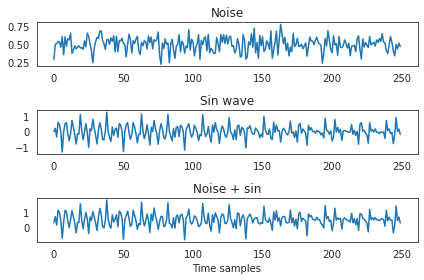

In [9]:
plt.subplot(3,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(3,1,2)
plt.title("Sin wave")
plt.plot(cw_signal[:250])
plt.subplot(3,1,3)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

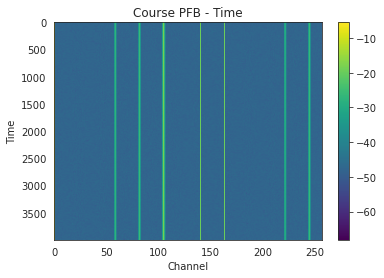

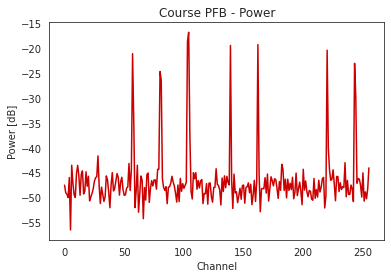

In [10]:
course_psd = pfb_spectrometer(data, M_course, P_course, n_int=4, window_fn="hamming")

plt.imshow(db(course_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.title("Course PFB - Time")
plt.show()

plt.plot(db(course_psd[0,1:]), c='#cc0000')
#plt.ylim(-50, -30)
#plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.title("Course PFB - Power")
plt.show()

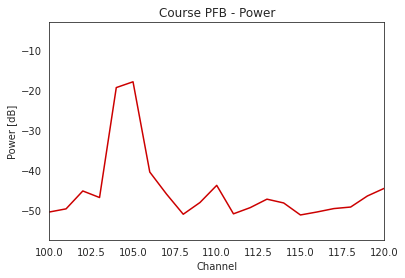

In [11]:
plt.plot(db(course_psd[1]), c='#cc0000')
#plt.ylim(-50, -30)
plt.xlim(100, 120)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.title("Course PFB - Power")
plt.show()

In [81]:
periodc = np.linspace(0, 0.05,256)

chan1c_val = []
chan2c_val = []

In [82]:
for p in periodc:
    t = np.arange(0, M*P*W)
    x = np.sin(t * p) + 0.001 #p random / multiply by ramp (linear function in freq space??????????????)
    course_psd_x = pfb_spectrometer(x, M_course, P_course, n_int=W, window_fn="hamming")
    chan1c_val.append(course_psd_x[0, 1])
    chan2c_val.append(course_psd_x[0, 2])

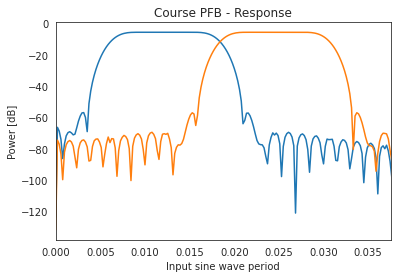

In [83]:
plt.plot(periodc, db(chan1c_val[:]))
plt.plot(periodc, db(chan2c_val[:]))
plt.xlim(0, 0.0375)
plt.title("Course PFB - Response")
plt.ylabel("Power [dB]")
plt.xlabel("Input sine wave period")
plt.show()

In [15]:
#chan1_val

In [16]:
#course_psd[:,108].shape

In [17]:
data_01 = course_psd[:3072,103]
data_0 = course_psd[:3072,104]
data_1 = course_psd[:3072,105]
data_2 = course_psd[:3072,106]
#data_1.shape

Fine PFB
----------------------

M = M_fine
P = P_fine

x = data_1
win_coeffs = generate_win_coeffs(M, P, window_fn="hamming") #built into scipy

plt.subplot(2,1,1)
plt.title("Time samples")
plt.plot(x)
plt.xlim(0, M*P*3)

plt.subplot(2,1,2)
plt.title("Window function")
plt.plot(win_coeffs)
plt.xlim(0, M*P)

plt.tight_layout(pad=1.0)
plt.show()

print(M_fine)
print(P_fine)

y_p = pfb_fir_frontend(x, win_coeffs, M, P) #defined above

print("n_taps: %i" % M)
print("n_branches: %i" % P)
print("Input signal shape: %i" % x.shape)
print("Window shape:       %i" % win_coeffs.shape)
print("Output data shape: %s" % str(y_p.shape))

plt.figure()
plt.imshow(y_p)
plt.xlabel("Branch")
plt.ylabel("Time")

plt.figure()
plt.plot(y_p[0], label="p=0")
plt.plot(y_p[1], label="p=1")
plt.plot(y_p[2], label="p=2")
plt.xlabel("Time sample, $n'$")
plt.legend()
plt.show()

In [18]:
fine_psd_01 = pfb_spectrometer(data_01, M_fine, P_fine, n_int=12, window_fn="hamming")
fine_psd_0 = pfb_spectrometer(data_0, M_fine, P_fine, n_int=12, window_fn="hamming")
fine_psd_1 = pfb_spectrometer(data_1, M_fine, P_fine, n_int=12, window_fn="hamming")
fine_psd_2 = pfb_spectrometer(data_2, M_fine, P_fine, n_int=12, window_fn="hamming")
#print(fine_psd)

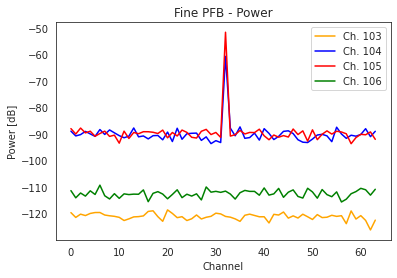

In [19]:
plt.plot(db(fine_psd_01[0,1:]), c='orange', label = "Ch. 103")
plt.plot(db(fine_psd_0[0,1:]), c='blue', label = "Ch. 104")
plt.plot(db(fine_psd_1[0,1:]), c='red', label = "Ch. 105")
plt.plot(db(fine_psd_2[0,1:]), c='green', label = "Ch. 106")
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.title("Fine PFB - Power")
plt.legend()
plt.show()

In [20]:
chtot = []
chtot.extend(fine_psd_01[0,1:])
chtot.extend(fine_psd_0[0,1:])
chtot.extend(fine_psd_1[0,1:])
chtot.extend(fine_psd_2[0,1:])

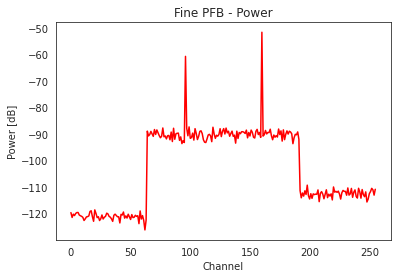

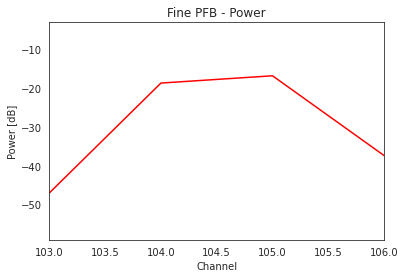

In [21]:
plt.plot(db(chtot), c='red')
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.title("Fine PFB - Power")
plt.show()

plt.plot(db(course_psd[0,:]), c='red')
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.title("Fine PFB - Power")
plt.xlim(103,106)
plt.show()

Fine Response
------------------------

In [77]:
period = np.linspace(0, 0.175,257) # make sure this is consitstant
W = 12
chan1_val = []
chan2_val = []

In [78]:
for p in period:
    t = np.arange(0, M*P*W)
    x = np.sin(t * p) + 0.001
    fine_psd_x = pfb_spectrometer(x, M_fine, P_fine, n_int=12, window_fn="hamming")
    chan1_val.append(fine_psd_x[0, 1])
    chan2_val.append(fine_psd_x[0, 2])

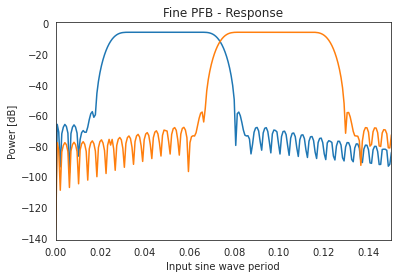

In [79]:
plt.plot(period, db(chan1_val[:]))
plt.plot(period, db(chan2_val[:]))
plt.xlim(0, 0.15)
plt.title("Fine PFB - Response")
plt.ylabel("Power [dB]")
plt.xlabel("Input sine wave period")
plt.show()

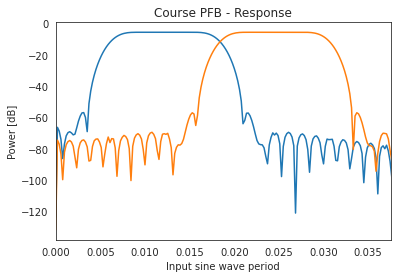

In [84]:
plt.plot(periodc, db(chan1c_val[:]))
plt.plot(periodc, db(chan2c_val[:]))
plt.xlim(0, 0.0375)
plt.title("Course PFB - Response")
plt.ylabel("Power [dB]")
plt.xlabel("Input sine wave period")
plt.show()